In [ ]:
! pip install adversarial-robustness-toolbox
! pip install shap
! pip install lime
import tensorflow as tf
import numpy as np
from art.attacks.evasion import FastGradientMethod
from art.utils import to_categorical
from art.estimators.classification import KerasClassifier
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import zipfile
import os
import cv2
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.utils import np_utils
import glob
import matplotlib.image as mpimg
import seaborn as sns
from art.attacks.evasion import BasicIterativeMethod
from art.attacks.evasion import ProjectedGradientDescent
import shap
from lime import lime_image


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 44.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=9ef912bcd35afe4b81384de4da1b21a95bc65ec50301e851dfab52af9fd8219d
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/ML_Project_006_012_017/Dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()#Close the zip file

In [ ]:
#defining categories for each kind of waste
categories = ['ewaste',
 'metal_cans',
 'plastic_bottles',
'plastic_bags',
'food_waste',
'paper_waste',
'wood_waste',
'leaf_waste'
 ]

In [ ]:
data = []
dir = "/tmp/Dataset/train/"

In [ ]:
#dividing the images into features and labels category where labels will be the target column for training the model
for category in categories:
  path = os.path.join(dir,category)
  label = categories.index(category)

  for img in os.listdir(path):
    imgpath = os.path.join(path,img)
    waste_img = cv2.imread(imgpath,0)
    waste_img = cv2.resize(waste_img,(32,32))
    image = np.array(waste_img).flatten()

    data.append([image,label])

In [ ]:
import pandas as pd
sdir=r'/tmp/Dataset/'
categories=[ 'train', 'val']
for category in categories:
    category_path=os.path.join(sdir, category)
    filepaths=[]
    labels=[]
    classlist=os.listdir(category_path)
    for klass in classlist:
        classpath=os.path.join(category_path,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if category=='train':
        train_df=pd.concat([Fseries, Lseries], axis=1)
    else:
        valid_df=pd.concat([Fseries, Lseries], axis=1)

In [ ]:
print (train_df.head())
print('train_df length: ', len(train_df), '  valid_df length: ', len(valid_df))
print (train_df['labels'].value_counts())

                                      filepaths        labels
0  /tmp/Dataset/train/plastic_bags/00000210.jpg  plastic_bags
1  /tmp/Dataset/train/plastic_bags/00000100.jpg  plastic_bags
2  /tmp/Dataset/train/plastic_bags/00000171.jpg  plastic_bags
3  /tmp/Dataset/train/plastic_bags/00000316.jpg  plastic_bags
4  /tmp/Dataset/train/plastic_bags/00000083.jpg  plastic_bags
train_df length:  14165   valid_df length:  1201
food_waste         10066
leaf_waste          1179
paper_waste          860
metal_cans           670
wood_waste           593
plastic_bottles      417
plastic_bags         200
ewaste               180
Name: labels, dtype: int64


In [ ]:
print (valid_df['labels'].value_counts())

leaf_waste         394
food_waste         229
paper_waste        212
plastic_bottles    130
metal_cans          69
wood_waste          59
ewaste              55
plastic_bags        53
Name: labels, dtype: int64


In [ ]:
sample_list=[]
max_size= 2000
groups=train_df.groupby('labels')
for label in train_df['labels'].unique():
    group=groups.get_group(label)
    sample_count=len(group)
    if sample_count> max_size:
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
    else:
        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
    sample_list.append(samples)
train_df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(train_df))
print (train_df['labels'].value_counts())

6099
food_waste         2000
leaf_waste         1179
paper_waste         860
metal_cans          670
wood_waste          593
plastic_bottles     417
plastic_bags        200
ewaste              180
Name: labels, dtype: int64


In [ ]:
import shutil
working_dir=r'./'
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in train_df['labels'].unique():
    dir_path=os.path.join(aug_dir,label)
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

['plastic_bags', 'ewaste', 'paper_waste', 'plastic_bottles', 'metal_cans', 'food_waste', 'wood_waste', 'leaf_waste']


In [ ]:
!pip install Keras-Preprocessing
from keras_preprocessing.image import ImageDataGenerator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.3 MB/s eta 0:00:00


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
target=2000 # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)
groups=train_df.groupby('labels') # group by class
for label in train_df['labels'].unique():  # for every class
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label
    sample_count=len(group)   # determine how many samples there are in this class
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images
        aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(400,400), class_mode=None, batch_size=1,
                                         shuffle=False, save_to_dir=target_dir, save_prefix='aug-',save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)
            aug_img_count += len(images)

Found 200 validated image filenames.


Palette images with Transparency expressed in bytes should be converted to RGBA images


Found 180 validated image filenames.
Found 860 validated image filenames.
Found 417 validated image filenames.
Found 670 validated image filenames.
Found 593 validated image filenames.
Found 1179 validated image filenames.


In [ ]:
aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    classpath=os.path.join(aug_dir, klass)
    flist=os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries=pd.Series(aug_fpaths, name='filepaths')
Lseries=pd.Series(aug_labels, name='labels')
aug_df=pd.concat([Fseries, Lseries], axis=1)
print ('length of aug_df" ', len(aug_df))
train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
train_df=train_df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
print ('length of train_df is: ', len(train_df))
print (train_df['labels'].value_counts())

length of aug_df"  9901
length of train_df is:  16000
ewaste             2000
plastic_bottles    2000
food_waste         2000
leaf_waste         2000
wood_waste         2000
plastic_bags       2000
paper_waste        2000
metal_cans         2000
Name: labels, dtype: int64


In [ ]:
# sample_list=[]
# max_size= 150
# groups=valid_df.groupby('labels')
# for label in valid_df['labels'].unique():
#     group=groups.get_group(label)
#     sample_count=len(group)
#     if sample_count> max_size:
#         samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
#     else:
#         samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
#     sample_list.append(samples)
# valid_df=pd.concat(sample_list, axis=0).reset_index(drop=True)
# print (len(valid_df))
# print (valid_df['labels'].value_counts())

In [ ]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True
# target=150 # set the target count for each class in df
# gen=ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, width_shift_range=.2,
#                               height_shift_range=.2, zoom_range=.2)
# groups=valid_df.groupby('labels') # group by class
# for label in valid_df['labels'].unique():  # for every class
#     group=groups.get_group(label)  # a dataframe holding only rows with the specified label
#     sample_count=len(group)   # determine how many samples there are in this class
#     if sample_count< target: # if the class has less than target number of images
#         aug_img_count=0
#         delta=target-sample_count  # number of augmented images to create
#         target_dir=os.path.join(aug_dir, label)  # define where to write the images
#         aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(400,400), class_mode=None, batch_size=1,
#                                          shuffle=False, save_to_dir=target_dir, save_prefix='aug-',save_format='jpg')
#         while aug_img_count<delta:
#             images=next(aug_gen)
#             aug_img_count += len(images)

In [ ]:
# aug_fpaths=[]
# aug_labels=[]
# classlist=os.listdir(aug_dir)
# for klass in classlist:
#     classpath=os.path.join(aug_dir, klass)
#     flist=os.listdir(classpath)
#     for f in flist:
#         fpath=os.path.join(classpath,f)
#         aug_fpaths.append(fpath)
#         aug_labels.append(klass)
# Fseries=pd.Series(aug_fpaths, name='filepaths')
# Lseries=pd.Series(aug_labels, name='labels')
# aug_df=pd.concat([Fseries, Lseries], axis=1)
# print ('length of aug_df" ', len(aug_df))
# valid_df=pd.concat([valid_df,aug_df], axis=0).reset_index(drop=True)
# valid_df=valid_df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
# print ('length of valid_df is: ', len(valid_df))
# print (valid_df['labels'].value_counts())

In [ ]:
height=400
width=400
channels=3
batch_size=20
img_shape=(height, width, channels)
img_size=(height, width)


def scalar(img):
    #img=img/127.5-1
    return img
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
sdir=r'/tmp/Dataset/'
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

Found 16000 validated image filenames belonging to 8 classes.
Found 1201 validated image filenames belonging to 8 classes.


In [ ]:
train = '/tmp/Dataset/train/'
val = '/tmp/Dataset/val/'


# CNN

In [ ]:
# Disable eager execution
tf.compat.v1.disable_eager_execution()

In [ ]:
datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_gen=datagen.flow_from_dataframe(

train_df,
x_col="filepaths",
y_col="labels",
batch_size=64,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

valid_gen=datagen.flow_from_dataframe(

valid_df,
x_col="filepaths",
y_col="labels",
batch_size=64,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 16000 validated image filenames belonging to 8 classes.
Found 1201 validated image filenames belonging to 8 classes.


# CNN

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l1_l2

def create_model(lr=0.001, epochs=10, dropout=0.2, optimizer='adam', loss='categorical_crossentropy',
                 activation='relu', clipnorm=1.0, momentum=0.9, decay=0.0, l1=0.0, l2=0.0,
                 no_of_conv_maxpool_layers=2, no_of_dense_layers=1, no_of_units_in_dense_layers=128,
                 kernel_size=(3, 3), conv2d_filters=[32, 64], pool_size=(2, 2), padding='same'):

    model = Sequential()

    for i in range(no_of_conv_maxpool_layers):
        if i == 0:
            model.add(Conv2D(conv2d_filters[i], kernel_size=kernel_size, activation=activation, input_shape=img_shape, padding=padding))
        else:
            model.add(Conv2D(conv2d_filters[i], kernel_size=kernel_size, activation=activation, padding=padding))
        model.add(MaxPool2D(pool_size=pool_size))
        model.add(BatchNormalization())

    model.add(Flatten())

    for _ in range(no_of_dense_layers):
        model.add(Dense(no_of_units_in_dense_layers, activation=activation, kernel_regularizer=l1_l2(l1=l1, l2=l2)))
        model.add(Dropout(dropout))

    model.add(Dense(class_count, activation='softmax'))

    if optimizer.lower() == 'adam':
        opt = Adam(lr=lr, clipnorm=clipnorm, decay=decay)
    elif optimizer.lower() == 'rmsprop':
        opt = RMSprop(lr=lr, clipnorm=clipnorm, momentum=momentum, decay=decay)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'epochs': [10, 20, 30],
    'dropout': [0.2, 0.4, 0.6],
    'optimizer': ['adam', 'rmsprop'],
    'loss': ['categorical_crossentropy', 'mse'],
    'activation': ['relu', 'sigmoid'],
    'clipnorm': [1.0, 5.0],
    'momentum': [0.9, 0.99],
    'decay': [0.0, 0.01, 0.1],
    'l1': [0.0, 0.01],
    'l2': [0.0, 0.01],
    'no_of_conv_maxpool_layers': [2, 3, 4],
    'no_of_dense_layers': [1, 2],
    'no_of_units_in_dense_layers': [128, 256],
    'kernel_size': [(3, 3), (5, 5)],
    'conv2d_filters': [[32, 64], [64, 128]],
    'pool_size': [(2, 2), (3, 3)],
    'padding': ['same', 'valid']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(train_gen, steps_per_epoch=train_steps, validation_data=valid_gen, epochs=10)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
Palette images with Transparency expressed in bytes should be converted to RGBA images


KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

cnn = tf.keras.Sequential()

# 1st layer
cnn.add(tf.keras.layers.Conv2D(filters=64, padding='same', strides=2, kernel_size=3, input_shape=(224, 224, 3)))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# 2nd layer
cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', strides=2, kernel_size=3))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# 3rd layer
cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', strides=2, kernel_size=3))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(8, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# Compile the model
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Wrap the model with the ART KerasClassifier
# art_classifier = KerasClassifier(model=cnn, clip_values=(0, 1))

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Train the model using the ART KerasClassifier
epochs = 20  # Adjust the number of epochs as needed
result = cnn.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[early_stopping])

Epoch 1/20
 26/250 [==>...........................] - ETA: 13:48 - batch: 12.5000 - size: 64.0000 - loss: 1.7014 - accuracy: 0.4153

Palette images with Transparency expressed in bytes should be converted to RGBA images


250/250 [==============================] - ETA: 0s - batch: 124.5000 - size: 64.0000 - loss: 1.1302 - accuracy: 0.5843

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


250/250 [==============================] - 725s 3s/step - batch: 124.5000 - size: 64.0000 - loss: 1.1302 - accuracy: 0.5843 - val_loss: 2.7456 - val_accuracy: 0.1973
Epoch 2/20
250/250 [==============================] - 700s 3s/step - batch: 124.5000 - size: 64.0000 - loss: 0.8556 - accuracy: 0.6878 - val_loss: 0.9208 - val_accuracy: 0.6786
Epoch 3/20
250/250 [==============================] - 693s 3s/step - batch: 124.5000 - size: 64.0000 - loss: 0.7695 - accuracy: 0.7200 - val_loss: 0.9457 - val_accuracy: 0.6961
Epoch 4/20
250/250 [==============================] - 697s 3s/step - batch: 124.5000 - size: 64.0000 - loss: 0.7057 - accuracy: 0.7495 - val_loss: 1.2877 - val_accuracy: 0.6020
Epoch 5/20
250/250 [==============================] - 691s 3s/step - batch: 124.5000 - size: 64.0000 - loss: 0.6527 - accuracy: 0.7666 - val_loss: 1.2523 - val_accuracy: 0.6187
Epoch 6/20
250/250 [==============================] - 694s 3s/step - batch: 124.5000 - size: 64.0000 - loss: 0.6188 - accuracy

##Optimal Solution

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Disable eager execution
tf.compat.v1.disable_eager_execution()

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col="filepaths",
    y_col="labels",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224)
)

valid_gen = datagen.flow_from_dataframe(
    valid_df,
    x_col="filepaths",
    y_col="labels",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224)
)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

cnn = tf.keras.Sequential()

# 1st layer
cnn.add(tf.keras.layers.Conv2D(filters=64, padding='same', strides=2, kernel_size=3, input_shape=(224, 224, 3)))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# 2nd layer
cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', strides=2, kernel_size=3))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# 3rd layer
cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', strides=2, kernel_size=3))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(8, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

# Compile the model
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the ART KerasClassifier
while True:
    result = cnn.fit(train_gen, epochs=1, validation_data=valid_gen, callbacks=[early_stopping])
    if early_stopping.stopped_epoch > 0:
        break


Found 16000 validated image filenames belonging to 8 classes.
Found 1201 validated image filenames belonging to 8 classes.


Palette images with Transparency expressed in bytes should be converted to RGBA images


250/250 [==============================] - ETA: 0s - batch: 124.5000 - size: 64.0000 - loss: 1.1192 - accuracy: 0.5924

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


 89/250 [=========>....................] - ETA: 6:51 - batch: 44.0000 - size: 64.0000 - loss: 0.2938 - accuracy: 0.9112

KeyboardInterrupt: ignored

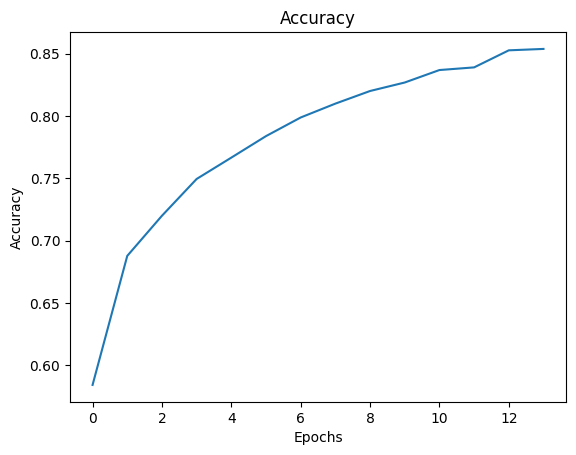

In [ ]:
#Plotting training accuracy curve
plt.title("Accuracy")
plt.plot(result.history["accuracy"])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

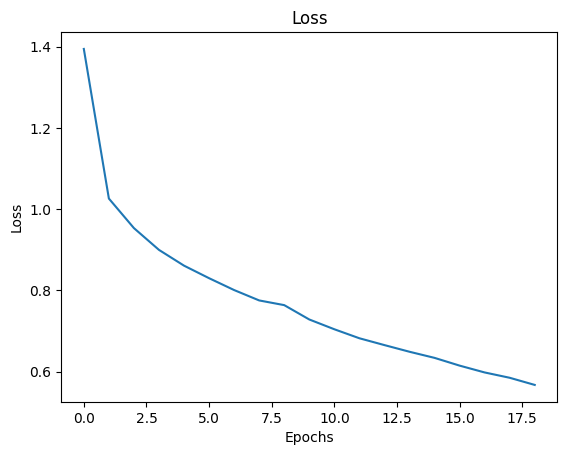

In [ ]:
#Plotting loss curve
plt.title("Loss")
plt.plot(result.history["loss"])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

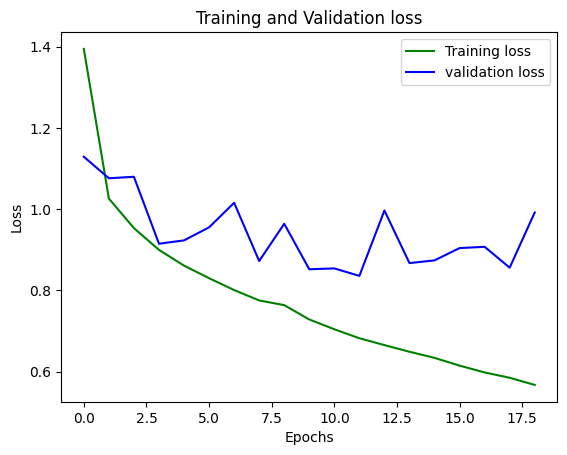

In [ ]:
#Plotting loss vs epoch curve fror training and validation loss
loss_train = result.history['loss']
loss_val = result.history['val_loss']
epochs = range(0,19)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

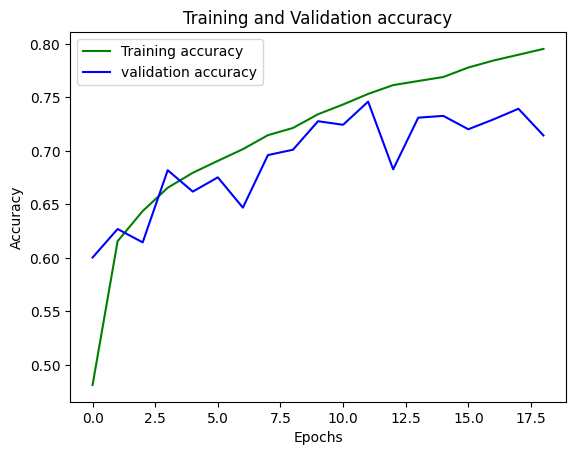

In [ ]:
#Plotting accuracy vs epoch curve fror training and validation accuracy
loss_train = result.history['accuracy']
loss_val = result.history['val_accuracy']
epochs = range(0,19)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import randint

# Define your CNN model
def create_model(learning_rate, batch_size, num_filters, kernel_size):
    model = tf.keras.Sequential()
    # 1st layer
    cnn.add(tf.keras.layers.Conv2D(filters=64, padding='same', strides=2, kernel_size=3, activation='relu', input_shape=(28, 28, 3)))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    # 2nd layer
    cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', strides=2, kernel_size=3, activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    # 3rd layer
    cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', strides=2, kernel_size=3, activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2))

    cnn.add(tf.keras.layers.Flatten())

    # Last Dense layer
    cnn.add(tf.keras.layers.Dense(8, activation='softmax'))

    return model

# Create a KerasClassifier wrapper for scikit-learn compatibility
model = KerasClassifier(build_fn=create_model)

# Define the hyperparameters and their ranges
param_dist = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_filters': randint(32, 128),
    'kernel_size': [3, 5, 7]
}

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

# Perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3)
random_result = random_search.fit(train_gen, epochs=10, validation_data=valid_gen, callbacks=[early_stopping])

# Print the best hyperparameters and corresponding performance
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
Palette images with Transparency expressed in bytes should be converted to RGBA images


ValueError: ignored

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

output_class = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"]

def waste_prediction(new_image):
    test_image = tf.keras.preprocessing.image.load_img(new_image, target_size=(224, 224))

    plt.axis("off")
    plt.imshow(test_image)  # Displaying test image
    plt.show()

    test_image = image.img_to_array(test_image) / 255
    test_image = np.expand_dims(test_image, axis=0)

    predicted_array = cnn.predict(test_image)  # Predicting accuracy of test image
    predicted_value = output_class[np.argmax(predicted_array)]
    predicted_accuracy = round(np.max(predicted_array) * 100, 2)

    print("Your waste material is ", predicted_value, " with ", predicted_accuracy, " % accuracy")

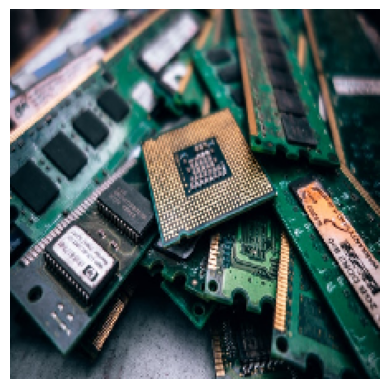

Your waste material is  ewaste  with  92.52  % accuracy


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [ ]:
image_path = '/content/00000004.jpg'
waste_prediction(image_path)

In [ ]:
# Save the trained model
cnn.save('model.h5')

# Explainability

**LIME**: LIME stands for Local Interpretable Model-agnostic Explanations. It is a Python library based on a paper from Ribeiro et al. to help you understand the behavior of your black-box classifier model. Currently, you can use LIME for a classifier model that classify tabular data, images, or texts.

The abbreviation of LIME itself should give you an intuition about the core idea behind it. LIME is:

**Model agnostic**, which means that LIME is model-independent. In other words, LIME is able to explain any black-box classifier you can think of.

**Interpretable**, which means that LIME provides you a solution to understand why your model behaves the way it does.

**Local,** which means that LIME tries to find the explanation of your black-box model by approximating the local linear behavior of your model.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Define a function to generate the Lime explanation image
def generate_explanation(image_path):
    explainer = lime_image.LimeImageExplainer()
    img = image.load_img(image_path, target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0
    explanation = explainer.explain_instance(img_array, cnn.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    return temp

  0%|          | 0/1000 [00:00<?, ?it/s]

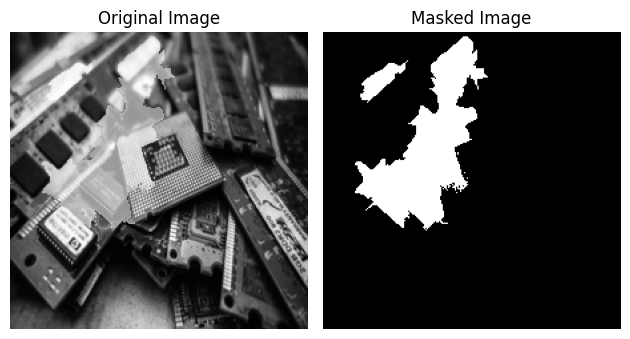

In [ ]:
from PIL import Image
import lime
from lime import lime_image

# Define a function to generate Lime explanations for an image
def generate_explanation(image_path):
    # Create a LimeImageExplainer object
    explainer = lime_image.LimeImageExplainer()

    # Open the image file and resize it to (224, 224)
    img = Image.open(image_path).resize((224, 224))

    # Convert the image to RGB mode
    img = img.convert("RGB")

    # Convert the image to a NumPy array and normalize the pixel values to the range [0, 1]
    img_array = np.array(img) / 255.0

    # Generate the Lime explanation for the image
    explanation = explainer.explain_instance(img_array, cnn.predict, top_labels=3, hide_color=0, num_samples=1000)

    return explanation

# Specify the path to your image file
image_path = '/content/00000004.jpg'

# Generate the Lime explanation for the image
explanation = generate_explanation(image_path)

# Define a function to visualize the Lime explanation
def visualize_explanation(explanation):
    # Check if the explanation has any labels
    if explanation.top_labels:
        # Get the label with the highest score
        label = explanation.top_labels[0]

        # Get the original image and the masked image from the explanation
        original_image, masked_image = explanation.get_image_and_mask(label, positive_only=False, hide_rest=False)

        # Convert the images to grayscale
        original_image = Image.fromarray((original_image * 255).astype(np.uint8)).convert('L')
        masked_image = Image.fromarray((masked_image * 255).astype(np.uint8)).convert('L')

        # Plot the original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Plot the masked image
        plt.subplot(1, 2, 2)
        plt.imshow(masked_image, cmap='gray')
        plt.title('Masked Image')
        plt.axis('off')

        # Display the plot
        plt.tight_layout()
        plt.show()
    else:
        print("No labels found in the explanation.")

# Visualize the Lime explanation
visualize_explanation(explanation)



  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 6


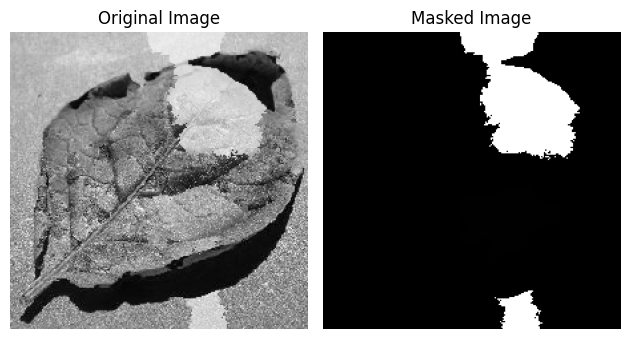

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 4


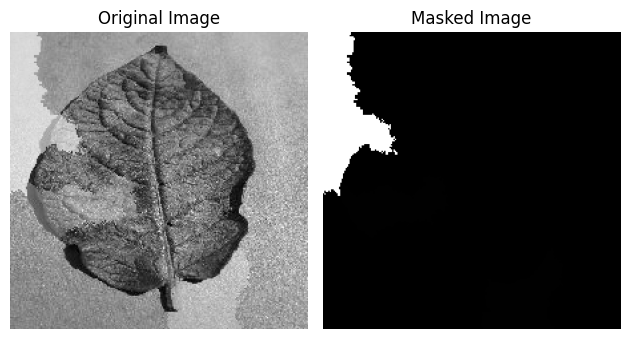

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 4


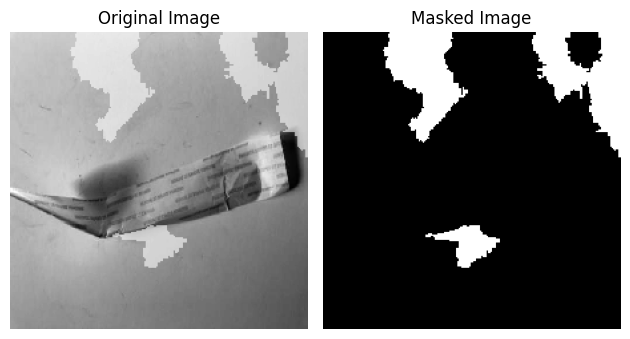

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 6


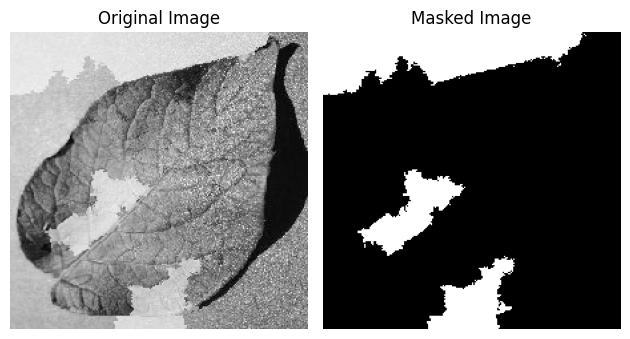

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 6


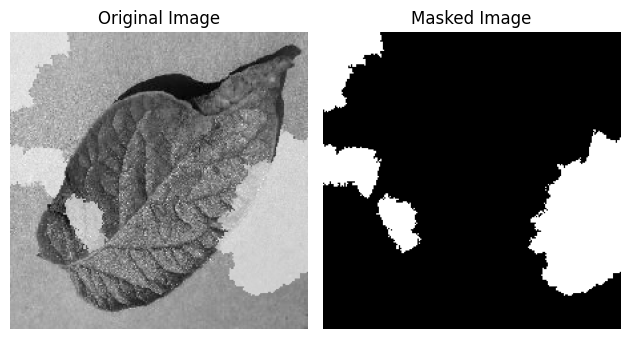

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 4


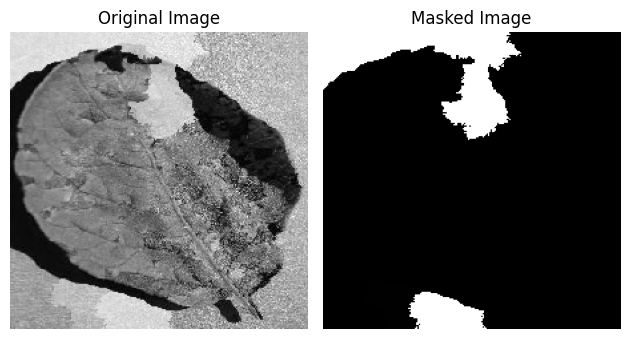

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 4


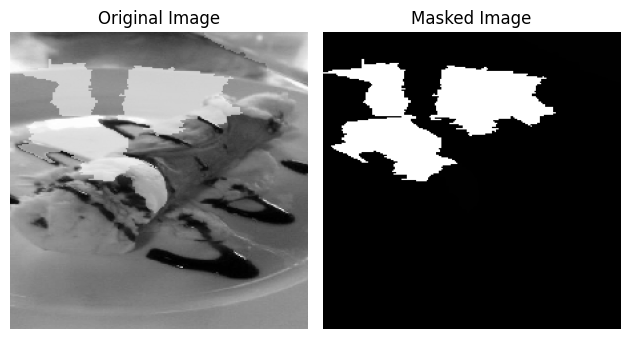

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 6


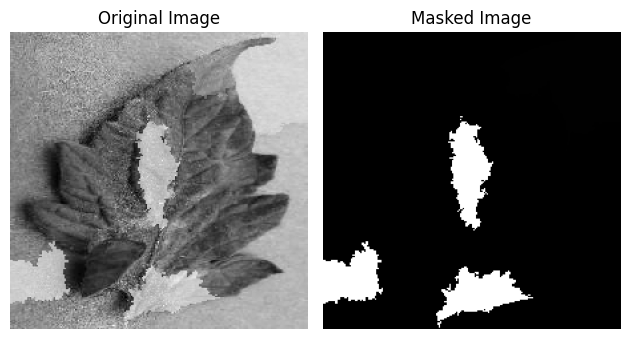

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 2


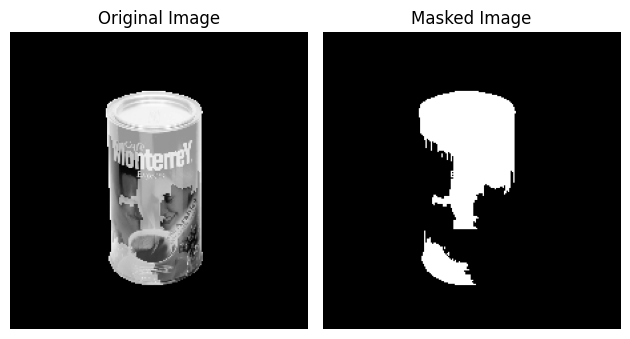

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 4


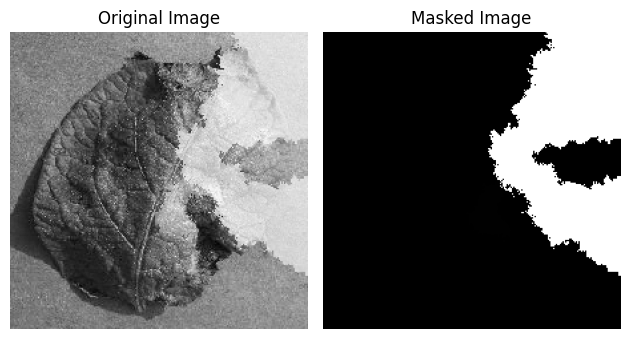

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 2


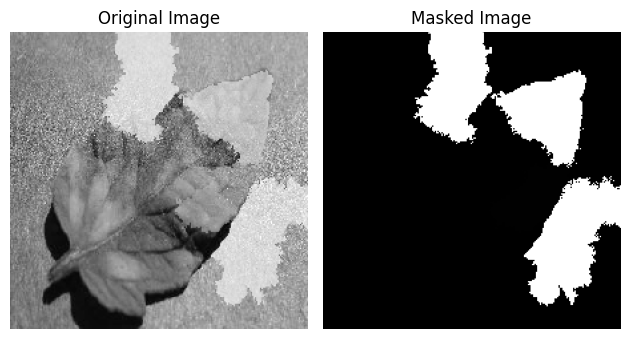

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 3


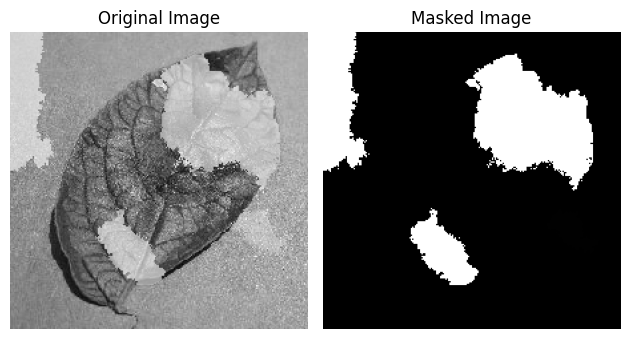

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 6


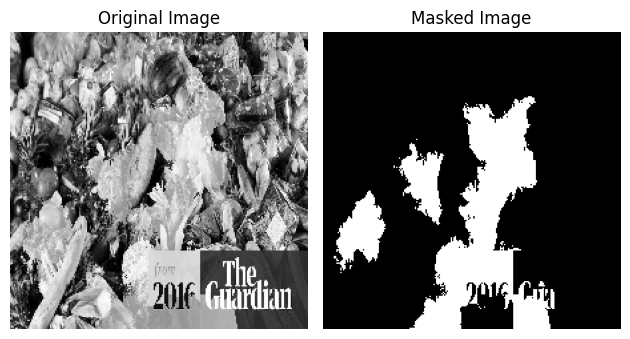

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 4


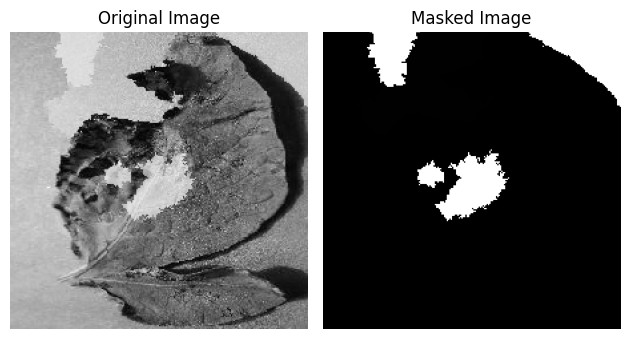

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 3


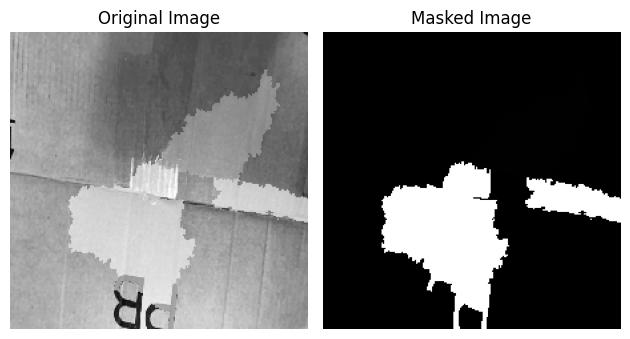

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 4


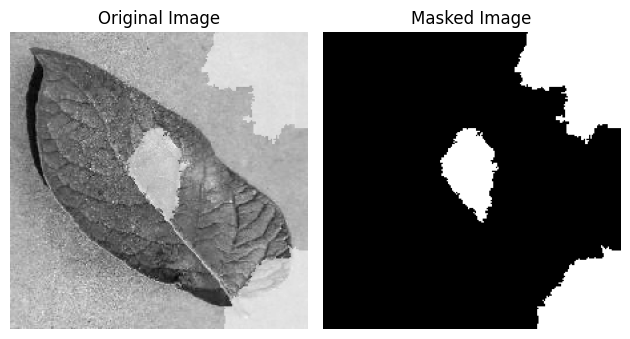

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 6


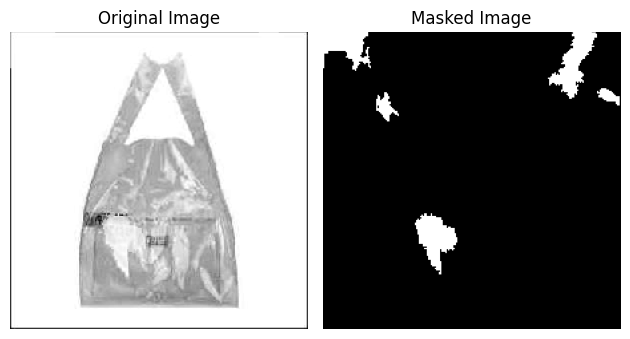

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 4


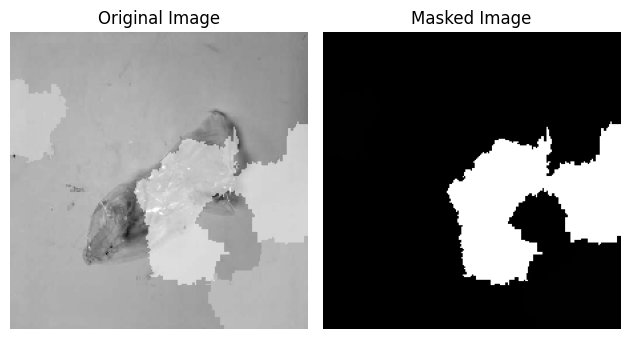

  0%|          | 0/1000 [00:00<?, ?it/s]

Actual Label: 4
Predicted Label: 4


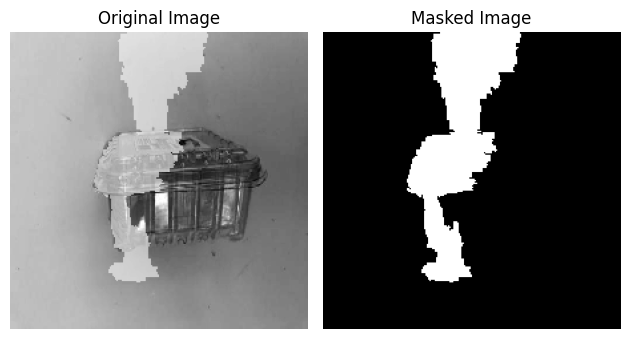

In [ ]:
from PIL import Image
import lime
from lime import lime_image

# Define a function to generate Lime explanations for an image
def generate_explanation(image_array):
    # Create a LimeImageExplainer object
    explainer = lime_image.LimeImageExplainer()

    # Select a single image from the batch
    image = image_array[0]

    # Convert the image array to grayscale
    image_gray = np.mean(image, axis=2)

    # Generate the Lime explanation for the image
    explanation = explainer.explain_instance(image_gray, cnn.predict, top_labels=3, hide_color=0, num_samples=1000)

    return explanation

# Determine the number of samples to select
num_samples = min(20, len(valid_gen))

# Select random samples from the dataset
random_indices = np.random.choice(len(valid_gen), size=num_samples, replace=False)

# Iterate over the random samples
for index in random_indices:
    # Get the image and label from the validation set
    image, label = valid_gen[index]

    # Generate the Lime explanation for the image
    explanation = generate_explanation(image)

    # Get the actual label and the predicted label
    actual_label = valid_gen.classes[np.argmax(label)]
    predicted_label = valid_gen.classes[np.argmax(cnn.predict(image))]

    # Print the actual and predicted labels
    print("Actual Label:", actual_label)
    print("Predicted Label:", predicted_label)

    # Visualize the Lime explanation
    visualize_explanation(explanation)
    print("\n")


In [ ]:
from PIL import Image
import lime
from lime import lime_image

# Define a function to generate Lime explanations for an image
def generate_explanation(image_path):
    # Create a LimeImageExplainer object
    explainer = lime_image.LimeImageExplainer()

    # Open the image file and resize it to (224, 224)
    img = Image.open(image_path).resize((224, 224))

    # Convert the image to RGB mode
    img = img.convert("RGB")

    # Convert the image to a NumPy array and normalize the pixel values to the range [0, 1]
    img_array = np.array(img) / 255.0

    # Generate the Lime explanation for the image
    explanation = explainer.explain_instance(img_array, cnn.predict, top_labels=1, hide_color=0, num_samples=1000)

    return explanation

# Specify the path to your image file
image_path = '/content/00000004.jpg'

# Generate the Lime explanation for the image
explanation_image = generate_explanation(image_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

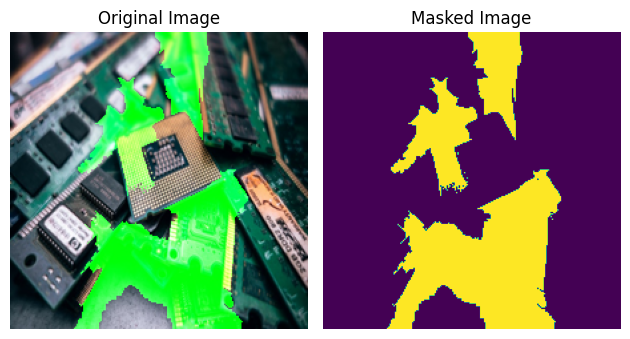

In [ ]:
import matplotlib.pyplot as plt

# Define a function to visualize the Lime explanation
def visualize_explanation(explanation):
    # Check if the explanation has any labels
    if explanation.top_labels:
        # Get the label with the highest score
        label = explanation.top_labels[0]

        # Get the original image and the masked image from the explanation
        original_image, masked_image = explanation.get_image_and_mask(label, positive_only=False, hide_rest=False)

        # Plot the original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')

        # Plot the masked image
        plt.subplot(1, 2, 2)
        plt.imshow(masked_image)
        plt.title('Masked Image')
        plt.axis('off')

        # Display the plot
        plt.tight_layout()
        plt.show()
    else:
        print("No labels found in the explanation.")

# Visualize the Lime explanation image
visualize_explanation(explanation_image)


**SHAP**

In [ ]:
sample_images = []
sample_labels = []

for _ in range(10):  # Change the number of samples as needed
    image, label = next(valid_gen)
    sample_images.append(image[0])
    sample_labels.append(label[0])

sample_images = np.array(sample_images)
sample_labels = np.argmax(np.array(sample_labels), axis=1)  # Convert one-hot encoded labels to class indices


In [ ]:
train_gen

In [ ]:
explainer = shap.GradientExplainer(cnn, train_gen[0][0])

In [ ]:
shap_values = explainer.shap_values(sample_images)

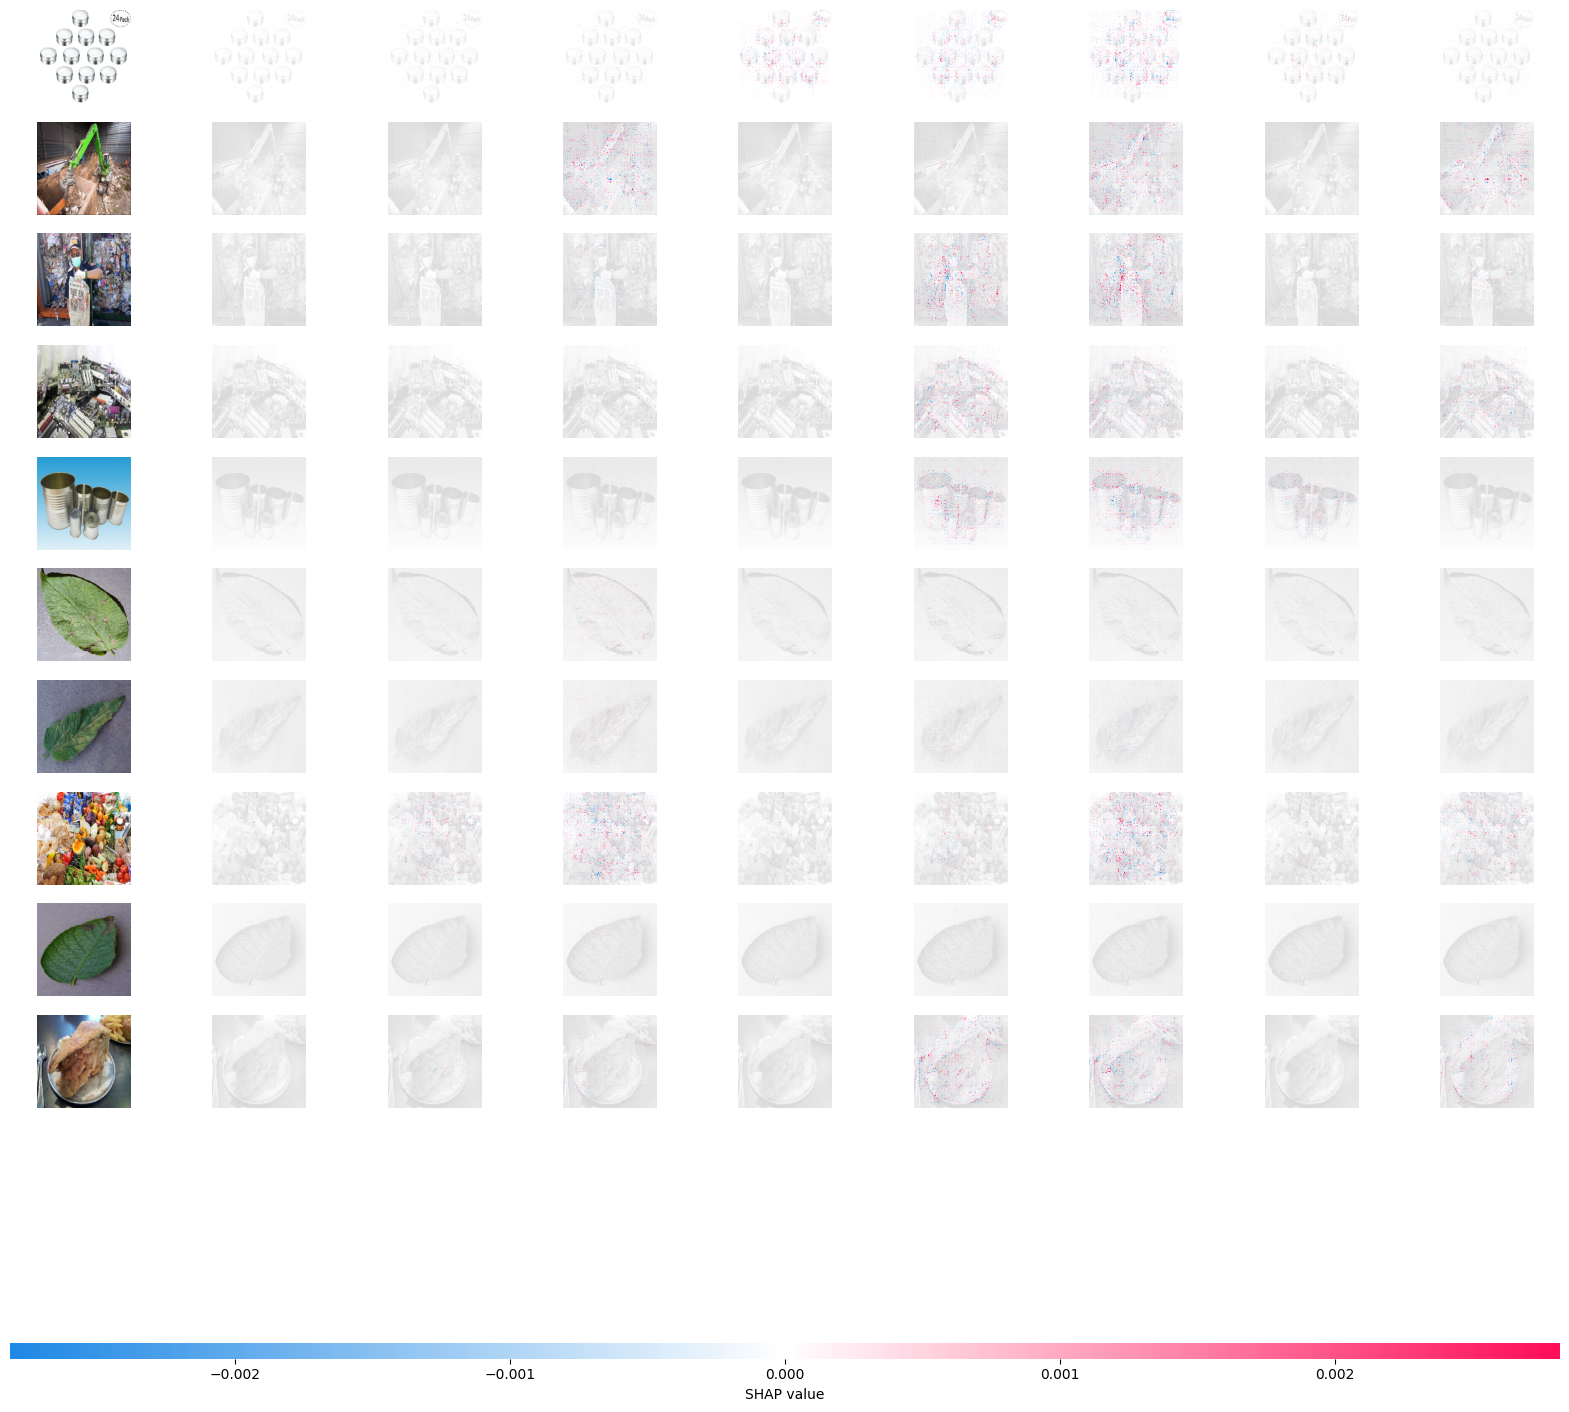

In [ ]:
# Plot the explanations
shap.image_plot(shap_values, sample_images)

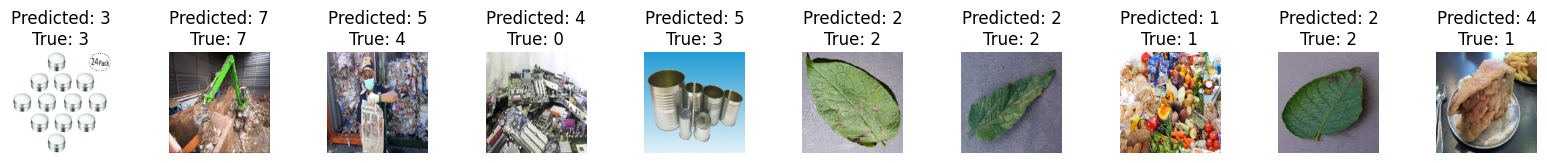

In [ ]:
import matplotlib.pyplot as plt

# Reshape sample_images to (num_samples, 224, 224, 3)
sample_images_reshaped = sample_images.reshape((-1, 224, 224, 3))

# Get model predictions for the sample images
predictions = cnn.predict(sample_images_reshaped)
predicted_labels = np.argmax(predictions, axis=1)

# Plot the images, predicted labels, and true labels
fig, axes = plt.subplots(ncols=len(sample_images_reshaped), figsize=(16, 8))
fig.tight_layout()

for i, (image, predicted_label, true_label) in enumerate(zip(sample_images_reshaped, predicted_labels, sample_labels)):
    # Plot the predicted image
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f'Predicted: {predicted_label}\nTrue: {true_label}')

plt.show()


In this visualization:

Red pixels represent positive SHAP values that contributed to classifying that image as that particular class.

Blue pixels represent negative SHAP values that contributed to not classifying that image as that particular class.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(sample_labels, predicted_labels)

# Calculate precision
precision = precision_score(sample_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(sample_labels, predicted_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(sample_labels, predicted_labels, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.6
Precision: 0.8
Recall: 0.6
F1 Score: 0.6666666666666666


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


##GRAD-CAM
 Grad-CAM provides a visual explanation of the model's decision-making process. It helps identify the areas that the model focuses on when making predictions, offering insights into the model's behavior and enabling interpretation of its decisions.

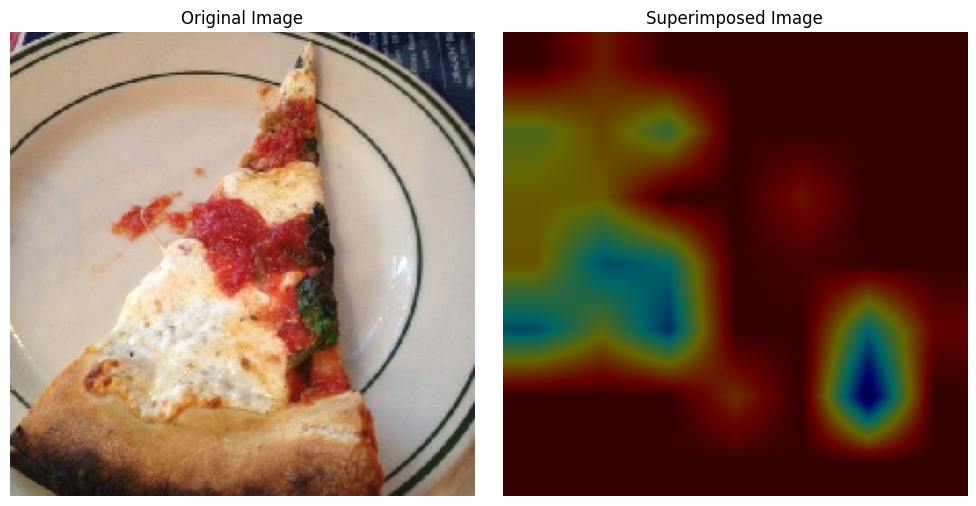

In [ ]:
def generate_grad_cam(model, img_array, layer_name):
    # Create a gradient model that takes the input and outputs the specified layer's output and the final predictions
    grad_model = tf.keras.Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        # Forward pass through the gradient model to get the intermediate layer output and predictions
        conv_outputs, predictions = grad_model(img_array)

        # Get the index of the predicted class
        class_index = tf.argmax(predictions[0])

        # Calculate the loss based on the predicted class
        loss = predictions[:, class_index]

    # Calculate the gradients of the loss with respect to the intermediate layer output
    grads = tape.gradient(loss, conv_outputs)

    # Compute the global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the intermediate layer output of the first image in the batch
    conv_outputs = conv_outputs[0]

    # Calculate the heatmap by multiplying the pooled gradients with the intermediate layer output
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Apply ReLU activation to remove negative values
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= tf.reduce_max(heatmap)

    return heatmap

# Specify the path to your image file
image_path = '/content/0_48.jpg'

# Load and preprocess the image
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Create a TensorFlow session
session = tf.compat.v1.keras.backend.get_session()

# Generate the Grad-CAM heatmap for the specified layer
heatmap = generate_grad_cam(cnn, img_array, layer_name='conv2d_2')

# Run the session to obtain the heatmap as a NumPy array
heatmap_np = session.run(heatmap)

# Resize the heatmap to match the size of the input image
heatmap_resized = cv2.resize(heatmap_np, (img_array.shape[2], img_array.shape[1]))

# Rescale the heatmap to the range [0, 255]
heatmap_rescaled = np.uint8(255 * heatmap_resized)

# Apply the colormap to the rescaled heatmap
heatmap_colormap = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)

# Convert the input image to uint8
img_array_uint8 = img_array.astype('uint8')

# Overlay the heatmap on the input image using weighted addition
superimposed_img = cv2.addWeighted(cv2.cvtColor(img_array_uint8[0], cv2.COLOR_RGB2BGR), 0.6, heatmap_colormap, 0.4, 0)

# Display the original and superimposed images side by side using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(superimposed_img)
axes[1].axis('off')
axes[1].set_title('Superimposed Image')

plt.tight_layout()
plt.show()


The heatmap represents the importance of each pixel in the input image with respect to the target class. Brighter areas in the heatmap indicate higher importance, suggesting that those regions have a stronger influence on the model's prediction. The heatmap is then overlaid on the original image using color mapping to highlight these important regions.

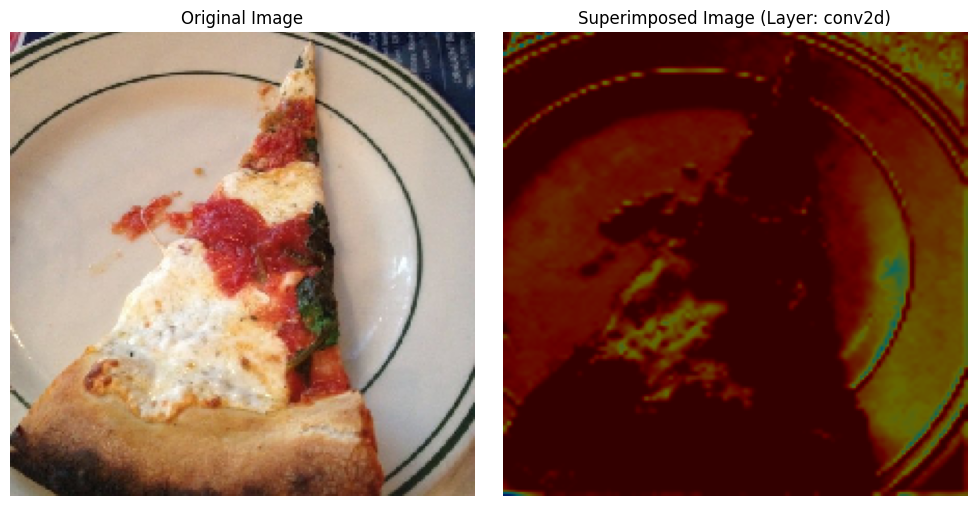

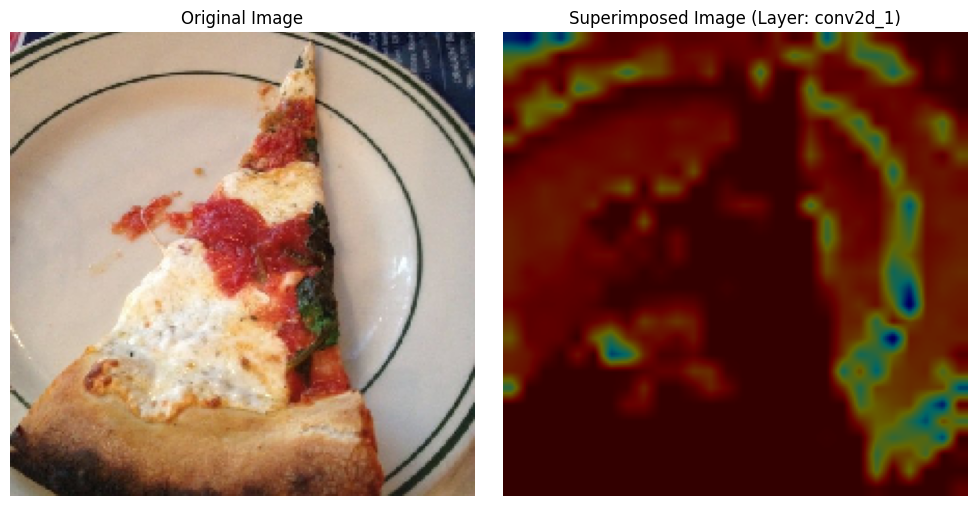

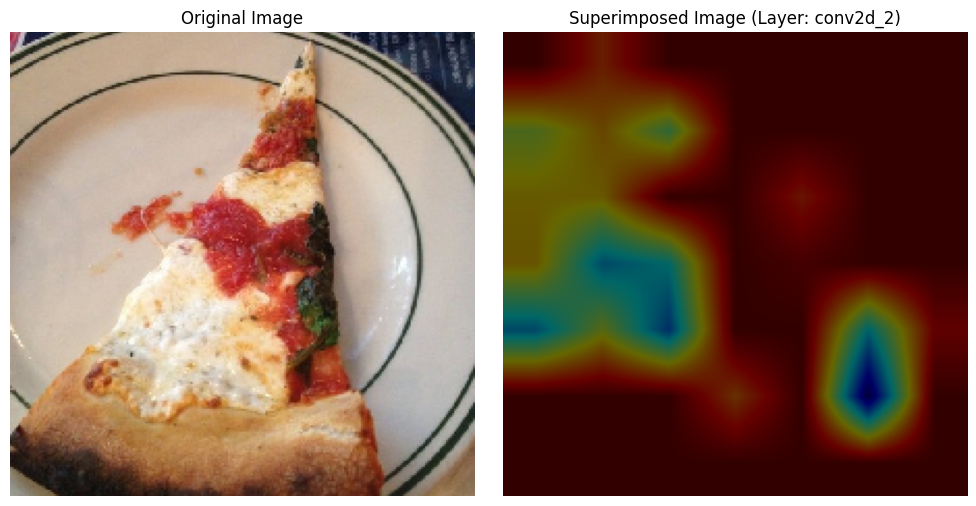

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_grad_cam(model, img_array, layer_name):
    # Create a gradient model that takes the input and outputs the specified layer's output and the final predictions
    grad_model = tf.keras.Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        # Forward pass through the gradient model to get the intermediate layer output and predictions
        conv_outputs, predictions = grad_model(img_array)

        # Get the index of the predicted class
        class_index = tf.argmax(predictions[0])

        # Calculate the loss based on the predicted class
        loss = predictions[:, class_index]

    # Calculate the gradients of the loss with respect to the intermediate layer output
    grads = tape.gradient(loss, conv_outputs)

    # Compute the global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the intermediate layer output of the first image in the batch
    conv_outputs = conv_outputs[0]

    # Calculate the heatmap by multiplying the pooled gradients with the intermediate layer output
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Apply ReLU activation to remove negative values
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= tf.reduce_max(heatmap)

    return heatmap

def generate_grad_cam_plots(model, img_array):
    # Get the names of the convolutional layers in the model
    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]

    # Create a TensorFlow session
    session = tf.compat.v1.keras.backend.get_session()

    # Generate Grad-CAM images for each layer
    for layer_name in layer_names:
        # Generate the heatmap using Grad-CAM
        heatmap = generate_grad_cam(model, img_array, layer_name=layer_name)

        # Convert the heatmap to a NumPy array
        heatmap_np = session.run(heatmap)

        # Resize the heatmap to match the size of the input image
        heatmap_resized = cv2.resize(heatmap_np, (img_array.shape[2], img_array.shape[1]))

        # Rescale the heatmap to the range [0, 255]
        heatmap_rescaled = np.uint8(255 * heatmap_resized)

        # Apply the colormap to the rescaled heatmap
        heatmap_colormap = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)

        # Convert the input image to uint8
        img_array_uint8 = img_array.astype('uint8')

        # Overlay the heatmap on the input image using weighted addition
        superimposed_img = cv2.addWeighted(cv2.cvtColor(img_array_uint8[0], cv2.COLOR_RGB2BGR), 0.6, heatmap_colormap, 0.4, 0)

        # Display the original and superimposed images side by side using matplotlib
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img)
        axes[0].axis('off')
        axes[0].set_title('Original Image')
        axes[1].imshow(superimposed_img)
        axes[1].axis('off')
        axes[1].set_title('Superimposed Image (Layer: {})'.format(layer_name))

        plt.tight_layout()
        plt.show()

# Specify the path to your image file
image_path = '/content/0_48.jpg'

# Load and preprocess the image
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Generate Grad-CAM plots for each layer
generate_grad_cam_plots(cnn, img_array)


Conv layer 1, being closer to the input layer, learns low-level features such as edges, corners, and textures. It focuses on capturing local patterns and details in the image.

Conv layer 2 builds upon the features learned by Conv layer 1 and extracts more complex patterns and higher-level features. It starts to detect more specific shapes and structures that are composed of multiple low-level features.

Conv layer 3 continues the progression by capturing even more complex and abstract features. It integrates information from the previous layers and looks for combinations of patterns that represent higher-level concepts or objects.

# Robustness-ART Classifier

**Evasion Attack**: Evasion attacks typically work by perturbing input data to cause a trained model to misclassify it. Evasion is done after training and during inference, i.e. when models are already deployed in production. Adversaries perform evasion attacks to avoid detection by AI systems. As an example, adversaries might run an evasion attack to cause the victim model to miss phishing emails. Evasion attacks might require access to the victim model.

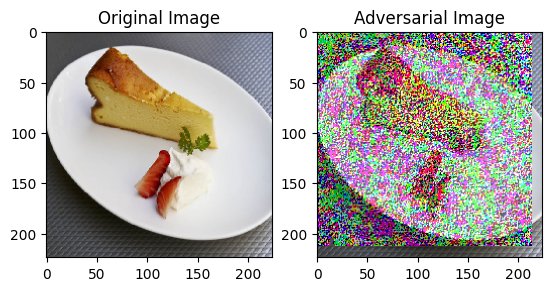

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Clean Accuracy: 0.765625
Adversarial Accuracy: 0.0
Clean Loss: 0.125
Adversarial Loss: 0.125


In [ ]:
# Create a classifier using the trained model
classifier = KerasClassifier(model=cnn, clip_values=(0, 1))

# Define an attack using the Fast Gradient Method
attack = FastGradientMethod(estimator=classifier, eps=0.5)

# Generate adversarial images from valid_gen
x_valid, y_valid = valid_gen.next()
x_valid_adv = attack.generate(x=x_valid, y=y_valid)

# View an adversarial image
index = 0  # Choose an index of the adversarial image to view

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(x_valid[index])
plt.title('Original Image')

# Display the adversarial image
plt.subplot(1, 2, 2)
plt.imshow(x_valid_adv[index])
plt.title('Adversarial Image')

plt.show()

# Evaluate the model on clean images
clean_preds = classifier.predict(x=x_valid)
clean_acc = np.mean(np.argmax(clean_preds, axis=1) == np.argmax(y_valid, axis=1))

# Evaluate the model on adversarial images
adv_preds = classifier.predict(x=x_valid_adv)
adv_acc = np.mean(np.argmax(adv_preds, axis=1) == np.argmax(y_valid, axis=1))

# Compare test losses
clean_loss = np.mean(classifier.predict(x_valid, batch_size=128)[0])
adv_loss = np.mean(classifier.predict(x_valid_adv, batch_size=128)[0])

# Compare test accuracies
print('Clean Accuracy:', clean_acc)
print('Adversarial Accuracy:', adv_acc)
print('Clean Loss:', clean_loss)
print('Adversarial Loss:', adv_loss)
